In [44]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
wd = 'release'

Index(['Processes', 'Average Time (s)', 'Std Dev (s)', 'Speedup',
       'Efficiency'],
      dtype='object')


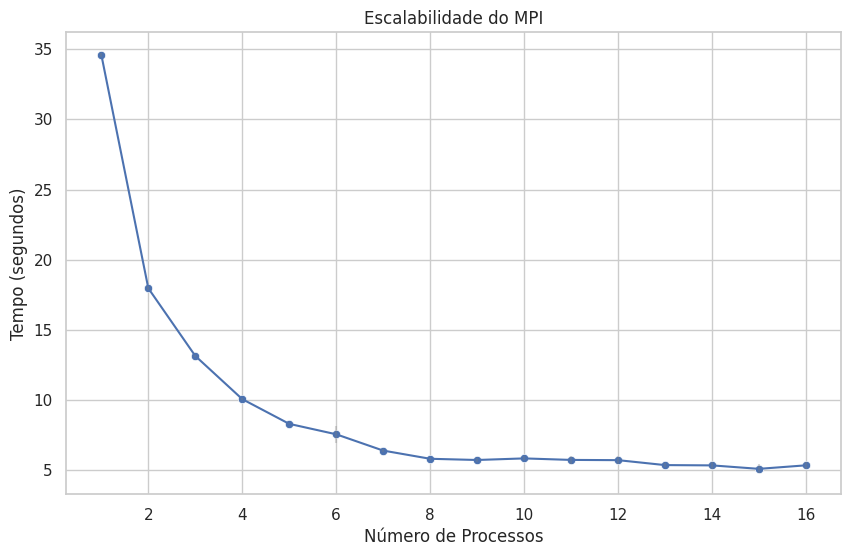

<Figure size 1000x600 with 0 Axes>

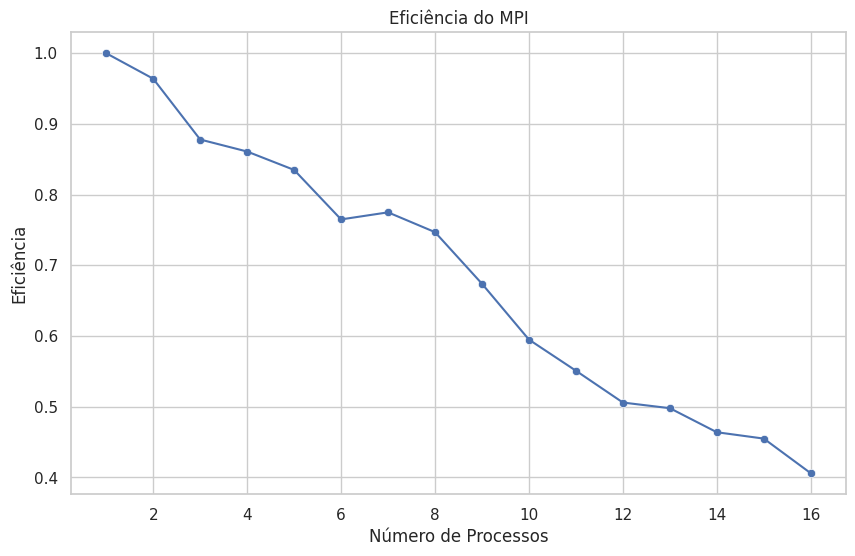

<Figure size 1000x600 with 0 Axes>

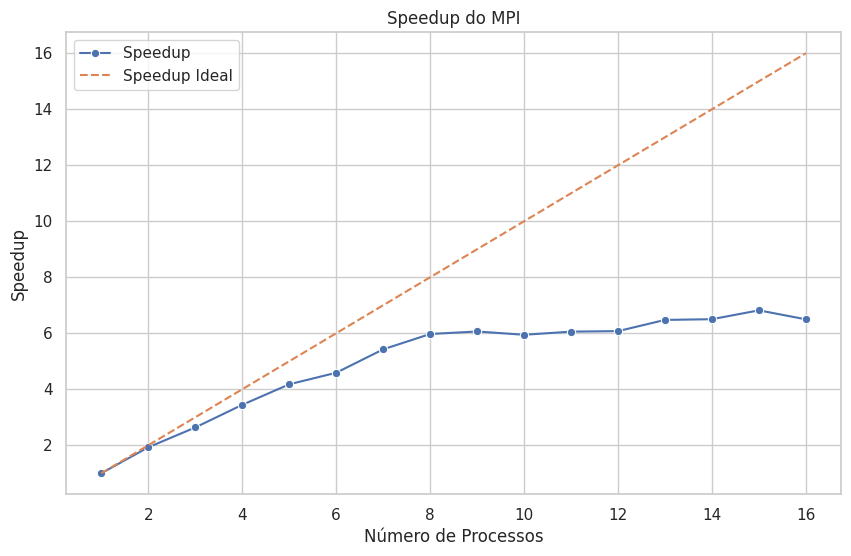

<Figure size 1000x600 with 0 Axes>

In [93]:
# Scaling
fn = os.path.join(wd, 'mpi_scaling_h_12_a_03_l_07.csv')
df = pd.read_csv(fn)

figsize = (10, 6)

print(df.columns)
# Translate to Brazilian Portuguese
df.rename(columns={'Processes': 'Processos', 'Average Time (s)': 'Tempo Médio (s)', 'Std Dev (s)': 'Desvio Padrão (s)', 'Efficiency': 'Eficiência'}, inplace=True)

# Plot Tempo
sns.scatterplot(data=df, x='Processos', y='Tempo Médio (s)')
sns.lineplot(data=df, x='Processos', y='Tempo Médio (s)')
plt.errorbar(x=df['Processos'], y=df['Tempo Médio (s)'], 
            yerr=df['Desvio Padrão (s)'],
            fmt='none', ecolor='gray', alpha=0.3)
plt.title('Escalabilidade do MPI')
plt.xlabel('Número de Processos')
plt.ylabel('Tempo (segundos)')
plt.figure(figsize=figsize)
plt.show()

# Plot Eficiência
sns.scatterplot(data=df, x='Processos', y='Eficiência')
sns.lineplot(data=df, x='Processos', y='Eficiência')
plt.title('Eficiência do MPI')
plt.xlabel('Número de Processos')
plt.ylabel('Eficiência')
plt.figure(figsize=figsize)
plt.show()

# Plot Speedup
df['Speedup'] = np.max(df['Tempo Médio (s)']) / df['Tempo Médio (s)']
df['Speedup Ideal'] = df['Processos']
sns.lineplot(data=df, x='Processos', y='Speedup', label='Speedup', marker='o', linestyle='-')
sns.lineplot(data=df, x='Processos', y='Speedup Ideal', label='Speedup Ideal', linestyle='--')
plt.title('Speedup do MPI')
plt.xlabel('Número de Processos')
plt.ylabel('Speedup')
plt.figure(figsize=figsize)
plt.show()

In [121]:
# Read best solutions
df = {'fn': [], 'best_cost': [], 'best_x': [], 'best_y': [], 'duration': []}
for fn in os.listdir(wd):
    if fn.startswith('run_h_24') and fn.endswith('_best.json'):
        # Best solution
        with open(os.path.join(wd, fn), 'r') as f:
            data = json.load(f)
            df['fn'].append(fn)
            df['best_cost'].append(data['best_cost'])
            # Convert to numpy array with 3 columns and drop the first row
            best_x = np.array(data['best_x']).reshape(-1, 3)[1:]
            best_y = np.array(data['best_y'])[1:]
            df['best_x'].append(best_x)
            df['best_y'].append(best_y)

        # Prunes
        fn = fn.replace('_best', '_stats')
        with open(os.path.join(wd, fn), 'r') as f:
            data = json.load(f)
            df['duration'].append(data['duration'])

df = pd.DataFrame(df)
def parse_fn(df):
    df['max_actuations'] = df['fn'].apply(lambda x: int(x.split('_a_')[1].split('_')[0]))
    df['h_max'] = df['fn'].apply(lambda x: int(x.split('_h_')[1].split('_')[0]))
    df['rank'] = df['fn'].apply(lambda x: int(x.split('_r_')[1].split('_')[0]))
    df['level'] = df['fn'].apply(lambda x: int(x.split('_l_')[1].split('_')[0]))
    df['processes'] = df['fn'].apply(lambda x: int(x.split('_n_')[1].split('_')[0]))
    df['uid'] = np.arange(len(df))

    print('max_actuations', set(df['max_actuations']))
    print('h_max', set(df['h_max']))
    print('rank', set(df['rank']))
    print('level', set(df['level']))
    print('processes', set(df['processes']))

    return df

df = parse_fn(df)

max_actuations {1, 2, 3}
h_max {24}
rank {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
level {7}
processes {1, 2, 4, 8, 16}


In [116]:
def parse_y(y):
    s = ''.join(f'{y[i]}' for i in range(len(y)))
    return s

def parse_x(x):
    s = ''
    num_pumps = x.shape[1]
    for j in range(num_pumps):
        t = '' if j == 0 else 11 * ' '
        s += t + parse_y(x[:, j]) + '\n'
    return s

print(42 * '=')
print('Melhores soluções para n=16')
print(42 * '=')
for h in set(df['h_max']):
    for a in set(df['max_actuations']):
        for n in set(df['processes']):
            df_agg = df[(df['h_max'] == h) & (df['max_actuations'] == a) & (df['processes'] == n)]
            if len(df_agg) == 0 or n != 16:
                continue
            print(f'h: {h}, a: {a}, n: {n}')
            best_cost = df_agg['best_cost'].min()
            # find the row with the best cost
            best_row = df_agg[df_agg['best_cost'] == best_cost]
            # check if there is only one row
            if len(best_row) != 1:
                raise ValueError('best_row is not unique')
            best_row = best_row.iloc[0]
            print(f'   best_cost: ${best_cost:.2f}')
            print(f'   best_y: {parse_y(best_row["best_y"])}')
            print(f'   best_x: {parse_x(best_row["best_x"])}')

Melhores soluções para n=16
h: 24, a: 1, n: 16
   best_cost: $3505.27
   best_y: 111122211111122220001111
   best_x: 111111100000000000001111
           000011111111111110000000
           000000000000011110000000

h: 24, a: 2, n: 16
   best_cost: $3431.54
   best_y: 111122222222221120001300
   best_x: 111111111111110000001100
           000011111111111110000100
           000000000000000010000100

h: 24, a: 3, n: 16
   best_cost: $3414.45
   best_y: 222111222211022220010300
   best_x: 111000000000011110000100
           111111111100011110000100
           000000111111000000010100



,processes,duration,duration_std,duration_min,duration_max,speedup,speedup_ideal,efficiency,unbalance
0,1,43.059755,0.000000,43.059755,43.059755,1.000000,1,1.000000,0.000000
1,2,24.558515,3.070097,18.418320,24.558515,1.753353,2,0.876677,0.333374
2,4,15.971517,2.899027,7.922091,15.971517,2.696034,4,0.674009,1.016073
3,8,9.621268,1.636440,4.250464,9.621268,4.475476,8,0.559435,1.263581
4,16,8.340418,1.640129,2.383127,8.340418,5.162781,16,0.322674,2.499779


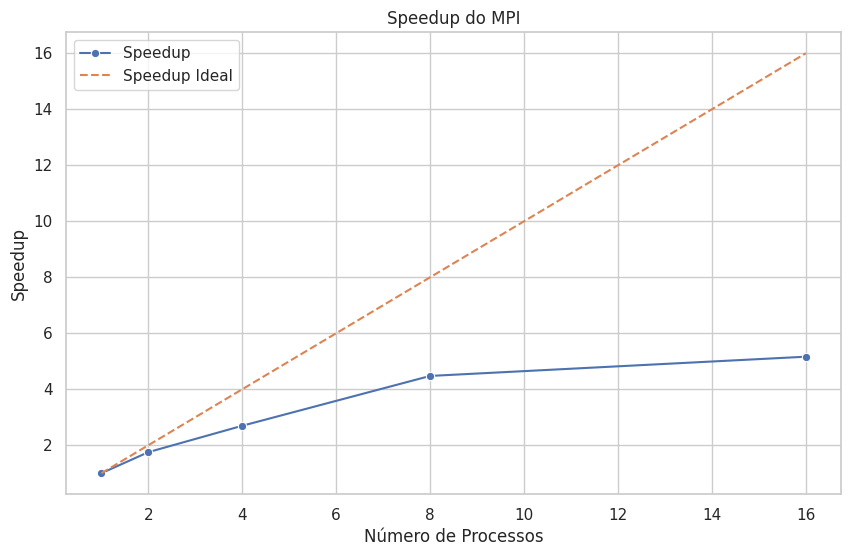

<Figure size 1000x600 with 0 Axes>

In [117]:
# Scaling for h=24, a=1
df_agg = df[(df['h_max'] == 24) & (df['max_actuations'] == 1)].copy()

# Calculate duration statistics
duration_std = {}
duration_min = {}
duration_max = {}
for n in set(df_agg['processes']):
    durations = df_agg[df_agg['processes'] == n]['duration']
    duration_std[n] = np.std(durations)
    duration_min[n] = np.min(durations)
    duration_max[n] = np.max(durations)
df_agg['duration_std'] = df_agg['processes'].apply(lambda x: duration_std[x])
df_agg['duration_min'] = df_agg['processes'].apply(lambda x: duration_min[x])
df_agg['duration_max'] = df_agg['processes'].apply(lambda x: duration_max[x])

df_agg = df_agg[['processes','duration','rank','duration_std','duration_min','duration_max']].groupby('processes').agg({'duration': 'max', 'duration_std': 'max', 'duration_min': 'min', 'duration_max': 'max'}).reset_index()
df_agg['speedup'] = np.max(df_agg['duration']) / df_agg['duration']
df_agg['speedup_ideal'] = df_agg['processes']
df_agg['efficiency'] = df_agg['speedup'] / df_agg['processes']
df_agg['unbalance'] = (df_agg['duration_max'] - df_agg['duration_min']) / df_agg['duration_min']

display(df_agg)

# Plot speedup
sns.lineplot(data=df_agg, x='processes', y='speedup', label='Speedup', marker='o', linestyle='-')
sns.lineplot(data=df_agg, x='processes', y='speedup_ideal', label='Speedup Ideal', linestyle='--')
plt.title('Speedup do MPI')
plt.xlabel('Número de Processos')
plt.ylabel('Speedup')
plt.figure(figsize=figsize)
plt.show()

In [143]:
# Prunes
df_prunes = {'fn': []}
for fn in os.listdir(wd):
    if fn.startswith('run_h_24') and fn.endswith('_stats.json'):
        with open(os.path.join(wd, fn), 'r') as f:
            data = json.load(f)
            df_prunes['fn'].append(fn)
            for k, v in data.items():
                if k == 'duration':
                    continue
                label = 'prune_' + k
                v = np.array(v)
                if label not in df_prunes:
                    df_prunes[label] = []
                df_prunes[label].append(v)

df_prunes = pd.DataFrame(df_prunes)
df_prunes['h_max'] = df_prunes['fn'].apply(lambda x: int(x.split('_h_')[1].split('_')[0]))
df_prunes['max_actuations'] = df_prunes['fn'].apply(lambda x: int(x.split('_a_')[1].split('_')[0]))
df_prunes['processes'] = df_prunes['fn'].apply(lambda x: int(x.split('_n_')[1].split('_')[0]))
df_prunes.rename(columns={'prune_NONE': 'FEASIBLE'}, inplace=True)
df_prunes = df_prunes[sorted(df_prunes.columns)]
display(df_prunes.columns)

h = 24
processes = 16
for a in set(df_prunes['max_actuations']):
    df_agg = df_prunes[(df_prunes['h_max'] == h) & (df_prunes['max_actuations'] == a) & (df_prunes['processes'] == processes)].copy()
    if len(df_agg) == 0:
        continue
    # drop the scalar columns
    print(f'h_max: {h}, max_actuations: {a}, processes: {processes}')
    df_agg.drop(columns=['fn', 'h_max', 'max_actuations', 'processes'], inplace=True)
    # all columns are int64, so we can sum them
    data = {}
    for col in df_agg.columns:
        data[col] = np.sum(df_agg[col])
    df_agg = pd.DataFrame(data)
    display(df_agg)

Index(['FEASIBLE', 'fn', 'h_max', 'max_actuations', 'processes',
       'prune_ACTUATIONS', 'prune_COST', 'prune_LEVELS', 'prune_PRESSURES',
       'prune_STABILITY'],
      dtype='object')

h_max: 24, max_actuations: 1, processes: 16


,FEASIBLE,prune_ACTUATIONS,prune_COST,prune_LEVELS,prune_PRESSURES,prune_STABILITY
0,0,0,0,0,0,0
1,0,0,0,0,904,0
2,0,0,0,0,291,0
3,0,0,0,0,205,0
4,0,0,0,0,20,0
5,0,0,0,0,55,0
6,0,0,0,0,27,0
7,0,0,0,0,51,0
8,6358,5281,0,0,141,0
9,12349,12558,0,0,525,0


h_max: 24, max_actuations: 2, processes: 16


,FEASIBLE,prune_ACTUATIONS,prune_COST,prune_LEVELS,prune_PRESSURES,prune_STABILITY
0,0,0,0,0,0,0
1,0,0,0,0,3767,0
2,0,0,0,0,990,0
3,0,0,0,0,506,0
4,0,0,0,0,64,0
5,0,0,0,0,126,0
6,0,0,0,0,44,0
7,0,0,0,0,122,0
8,35115,3523,0,0,614,0
9,115939,20569,0,0,3952,0


h_max: 24, max_actuations: 3, processes: 16


,FEASIBLE,prune_ACTUATIONS,prune_COST,prune_LEVELS,prune_PRESSURES,prune_STABILITY
0,0,0,0,0,0,0
1,0,0,0,0,4096,0
2,0,0,0,0,1024,0
3,0,0,0,0,512,0
4,0,0,0,0,64,0
5,0,0,0,0,128,0
6,0,0,0,0,44,0
7,0,0,0,0,122,0
8,40853,53,0,0,670,0
9,157573,1019,0,0,4820,0
